### Import libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np

import h5py

import seaborn as sns

from iminuit import Minuit

from functools import partial
from numba import njit

from joblib import Parallel, delayed

from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d

import os, sys
sys.path.append(os.path.abspath('..'))

import constants, functions

### First Chi2 estimation for window

In [12]:
N = 100
is_highres = False
n_om = N
n_s8 = N
n_gamma = N
n_H0 = N
n_rd = N

nbins = 100

H0_min = 50
H0_max = 100
rd_min = 100
rd_max = 200

if is_highres:
    om_min = 0.250
    om_max = 0.5
    s8_min = 0.5
    s8_max = 1.05
    gamma_min = 0
    gamma_max = 1.2
    FOLDER = "highres"
else:
    om_min = .05
    om_max = 1
    s8_min = 0.4
    s8_max = 1.2
    gamma_min = -0.5
    gamma_max = 2
    FOLDER = "lowres"

omega_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

rd_vals = np.asarray(np.linspace(rd_min, rd_max, n_rd))
H0_vals = np.asarray(np.linspace(H0_min, H0_max, n_H0))

with h5py.File('../../data/posteriors_DESY3_arico.hdf5', 'r') as f:
     S8_data = f['S8'][:]
     Om_data = f['omega_matter'][:]
     sigma8_data = S8_data * np.sqrt(.3/Om_data)

min_Om_desy3, max_Om_desy3 = np.min(Om_data), np.max(Om_data)
min_sigma8_desy3, max_sigma8_desy3 = np.min(sigma8_data), np.max(sigma8_data)

X, Y = np.meshgrid(omega_vals, sigma_vals)
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([Om_data, sigma8_data])
kde = gaussian_kde(values)
density = kde(positions).reshape(X.shape)

P = density / np.max(density)
with np.errstate(divide='ignore'):
    delta_chi2_grid_desy3 = -2 * np.log(P)
    delta_chi2_grid_desy3[np.isinf(delta_chi2_grid_desy3)] = np.nanmax(delta_chi2_grid_desy3) + 1

@njit
def chi2_rsd_bao_sn1a_wl(omega_array, sigma_array, z_data_rsd, z_data_bao, fs8_data, fs8_err_plus, fs8_err_minus, dmrd_data, dmrd_err, n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, c, chi2_desy3_grid, omega, sigma, gamma, rd, H0, M):
    # if omega > min_Om_desy3 and omega < max_Om_desy3 and sigma > min_sigma8_desy3 and sigma < max_sigma8_desy3:
    #     chi2_desy3 = 0
    # else:
    #     chi2_desy3 = 0
    i_omega, i_sigma = np.argmin(abs(omega_array-omega)), np.argmin(abs(sigma_array - sigma))
    chi2_desy3 = chi2_desy3_grid[i_omega, i_sigma]
    # print(f"({omega}, {sigma}) : ({i_omega}, {i_sigma}) >> {chi2_desy3}")
    return functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + functions.chi2_bao_dmrd(z_data_bao, dmrd_data, dmrd_err, c, omega, rd, H0) + functions.chi2_panth(n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, H0, M, c) + chi2_desy3

### Defining parameters
z_data_bao = np.asarray(constants.z_data_bao)
Dmrd_data = np.asarray(constants.Dmrd_data)
Dmrd_err = np.asarray(constants.Dmrd_err)

z_data_rsd = np.asarray(constants.z_data)
fs8_data = np.asarray(constants.fs8_data)
fs8_err_plus = np.asarray(constants.fs8_err_plus)
fs8_err_minus = np.asarray(constants.fs8_err_minus)

z_data_panth = np.asarray(constants.z_data_panth)
is_calibrator_panth = np.asarray(constants.is_calibrator_panth)
m_b_corr_panth = np.asarray(constants.m_b_corr_panth)
ceph_dist_panth = np.asarray(constants.ceph_dist_panth)
inv_cov_panth = np.asarray(constants.inv_cov_panth)
n_panth = constants.n_panth

c = constants.C

delta_chi2_grid_desy3 = np.asarray(delta_chi2_grid_desy3)

chi2_func = partial(
    chi2_rsd_bao_sn1a_wl,
    omega_vals,
    sigma_vals,
    z_data_rsd,
    z_data_bao,
    fs8_data,
    fs8_err_plus,
    fs8_err_minus,
    Dmrd_data,
    Dmrd_err,
    n_panth,
    z_data_panth,
    is_calibrator_panth,
    m_b_corr_panth,
    ceph_dist_panth,
    inv_cov_panth,
    c,
    delta_chi2_grid_desy3
)

In [13]:
minimizer = Minuit(chi2_func, omega=0.315, sigma=0.811, gamma=0.55, rd=147, H0=73.4, M=-19.25)

minimizer.limits["omega"] = (om_min, om_max)
minimizer.limits["sigma"] = (s8_min,s8_max)
minimizer.limits["gamma"] = (gamma_min,gamma_max)
minimizer.fixed["M"] = True
# minimizer.fixed["gamma"] = True
# minimizer.fixed["sigma"] = True
# minimizer.limits["rd"] = (rd_min, rd_max)
minimizer.limits["H0"] = (H0_min, H0_max)
minimizer.fixed["rd"] = True
# minimizer.fixed["H0"] = True

result = minimizer.migrad()

print(f"\nRésultats du fit :")
print(f"Chi2 = {minimizer.fval:.2f} \n")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega']:.3f} ± {minimizer.errors['omega']:.4f}")
print(f"rd = {minimizer.values['rd']:.3f} ± {minimizer.errors['rd']:.4f}")
print(f"H0 = {minimizer.values['H0']:.3f} ± {minimizer.errors['H0']:.3f}\n")

print(result)


Résultats du fit :
Chi2 = 1715.14 

Paramètres estimés :
Ωm = 0.217 ± 0.0068
rd = 147.000 ± 1.4700
H0 = 74.097 ± 0.170

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1715                       │              Nfcn = 112              │
│ EDM = 0.000115 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴───────

### Calculations

In [8]:
from time import time
from scipy.integrate import quad
import math

def chi2_om_s8_func(omega, sigma, gamma_min, gamma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, sigma=sigma, gamma=0.55, rd = 147.05, H0 = 73.4, M=-19.25)
    minimizer.fixed["omega"] = True
    minimizer.fixed["sigma"] = True
    minimizer.limits["gamma"] = (gamma_min, gamma_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(omega, gamma, sigma_min, sigma_max, chi2_func):
    minimizer = Minuit(chi2_func, omega=omega, gamma=gamma, sigma=0.7, rd = 147.05, H0 = 73.4, M=-19.25)
    minimizer.fixed["omega"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["sigma"] = (sigma_min, sigma_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(sigma, gamma, omega_min, omega_max, chi2_func):
    minimizer = Minuit(chi2_func, sigma=sigma, gamma=gamma, omega=0.3, rd = 147.05, H0 = 73.4, M=-19.25)
    minimizer.fixed["sigma"] = True
    minimizer.fixed["gamma"] = True
    minimizer.limits["omega"] = (omega_min, omega_max)
    # minimizer.fixed["H0"] = True
    # minimizer.fixed["rd"] = True
    minimizer.limits["rd"] = (rd_min, rd_max)
    minimizer.limits["H0"] = (H0_min, H0_max)
    minimizer.fixed["M"] = True
    minimizer.migrad()
    return minimizer.fval

t = time()
chi2_om_sig8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(omega, sigma, gamma_min, gamma_max, chi2_func) for omega in omega_vals for sigma in sigma_vals)
chi2_grid1 = np.array(chi2_om_sig8).reshape(n_om, n_s8)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

t = time()
chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(omega, gamma, s8_min, s8_max, chi2_func) for omega in omega_vals for gamma in gamma_vals)
chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
t = time() - t
print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

t = time()
chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(sigma, gamma, om_min, om_max, chi2_func) for sigma in sigma_vals for gamma in gamma_vals)
chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
t = time() - t
print("chi2_grid 3 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 3 min 57.1 s.
chi2_grid 2 calculated in 3 min 22.4 s.
chi2_grid 3 calculated in 3 min 54.9 s.


In [9]:
np.savez("../../output/3-chi2_RSD_PANTH_DESIDR2/" + FOLDER + "/chi2_grid1.npz", grid1=chi2_grid1)
np.savez("../../output/3-chi2_RSD_PANTH_DESIDR2/" + FOLDER + "/chi2_grid2.npz", grid2=chi2_grid2)
np.savez("../../output/3-chi2_RSD_PANTH_DESIDR2/" + FOLDER + "/chi2_grid3.npz", grid3=chi2_grid3)

### Plot

(0.75, 0.34595959595959597)
Incertitude $\sigma_8$ : xmin = 0.68, xmax = 0.83 : (+0.07, -0.08)
Incertitude $\Omega_m$ : ymin = 0.32, ymax = 0.37 : (+0.02, -0.02)

(0.5333333333333333, 0.34595959595959597)
Incertitude $\gamma$ : xmin = 0.35, xmax = 0.72 : (+0.18, -0.18)
Incertitude $\Omega_m$ : ymin = 0.32, ymax = 0.37 : (+0.02, -0.02)

(0.5212121212121212, 0.75)
Incertitude $\gamma$ : xmin = 0.35, xmax = 0.72 : (+0.17, -0.19)
Incertitude $\sigma_8$ : ymin = 0.68, ymax = 0.83 : (+0.07, -0.08)



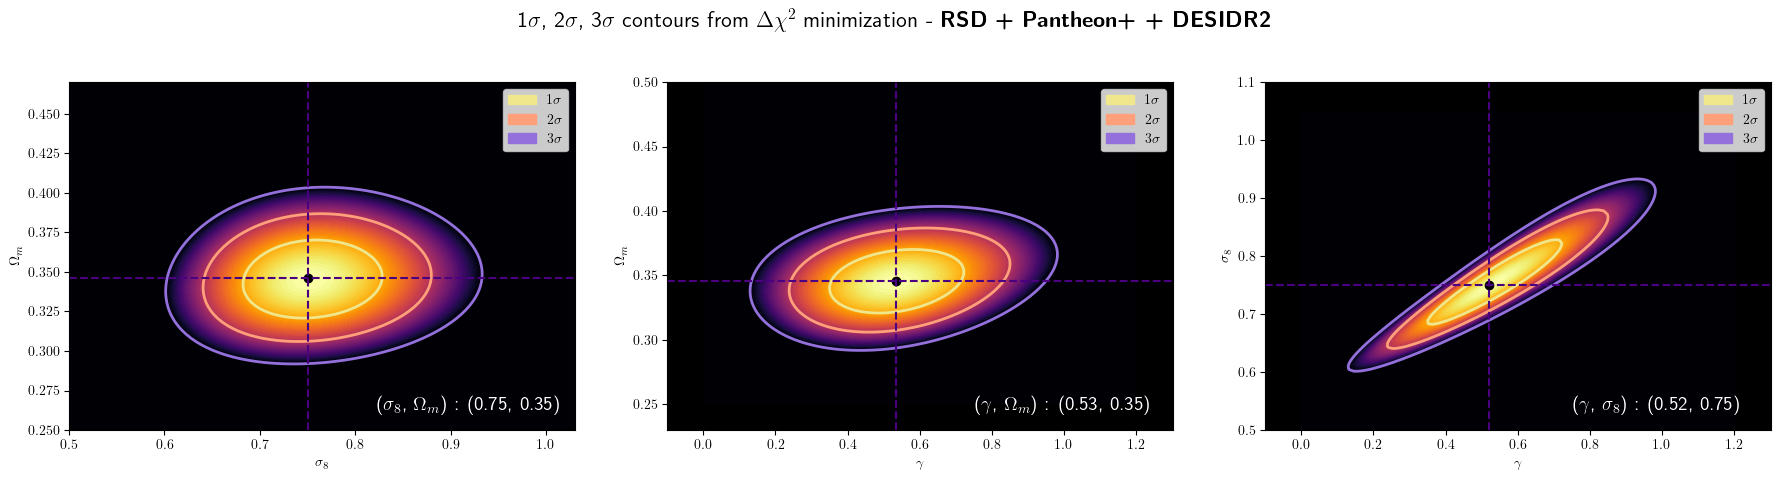

In [12]:
from matplotlib.patches import Patch
def display_all_chi2(chi2_grids, axes):
    levels = [2.3, 6.17, 11.8]
    colors = ['khaki', 'lightsalmon', 'mediumpurple']

    axes_titles = [
        (r'$\sigma_8$', r'$\Omega_m$', 0),
        (r'$\gamma$', r'$\Omega_m$', 1),
        (r'$\gamma$', r'$\sigma_8$', 2)
    ]

    for ax, (xlabel, ylabel, axis) in zip(axes, axes_titles):
        chi2_grid = chi2_grids[axis]
        
        sigma_vals = np.asarray(np.linspace(s8_min, s8_max, chi2_grid.shape[0]))
        omega_vals = np.asarray(np.linspace(om_min, om_max, chi2_grid.shape[0]))
        gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, chi2_grid.shape[0]))

        if axis == 0:
            X, Y = np.meshgrid(sigma_vals, omega_vals)
        elif axis == 1:
            X, Y = np.meshgrid(gamma_vals, omega_vals)
        elif axis == 2:
            X, Y = np.meshgrid(gamma_vals, sigma_vals)

        chi2_min = np.min(chi2_grid)
        delta_chi2 = chi2_grid - chi2_min

        delta_chi2_clipped = np.clip(delta_chi2, a_min=None, a_max=levels[2])
        
        cf = ax.contourf(X, Y, delta_chi2_clipped, levels=100, cmap='inferno_r')
        
        for level, color in zip(levels, colors):
            cs = ax.contour(X, Y, delta_chi2, levels=[level], colors=[color], linewidths=2)

            # Get incertitude
            if level == 2.3:
                mask = delta_chi2 <= level

                x_coords = X[mask]
                y_coords = Y[mask]

                xmin, xmax = np.min(x_coords), np.max(x_coords)
                ymin, ymax = np.min(y_coords), np.max(y_coords)

        legend_handles = [
            Patch(color='khaki', label=r'$1\sigma$'),
            Patch(color='lightsalmon', label=r'$2\sigma$'),
            Patch(color='mediumpurple', label=r'$3\sigma$')
        ]
        ax.legend(handles=legend_handles, loc='upper right')

        min_idx = np.unravel_index(np.argmin(delta_chi2), delta_chi2.shape)
        x_min = X[min_idx]
        y_min = Y[min_idx]
        ax.plot(x_min, y_min, 'ko', label='Best-fit')
        ax.axhline(y_min, color='indigo', linestyle='--')
        ax.axvline(x_min, color='indigo', linestyle='--')

        print((x_min, y_min))
        print(f"Incertitude {axes_titles[axis][0]} : xmin = {xmin:.2f}, xmax = {xmax:.2f} : (+{round(x_min - xmin, 2)}, -{round(xmax - x_min, 2)})")
        print(f"Incertitude {axes_titles[axis][1]} : ymin = {ymin:.2f}, ymax = {ymax:.2f} : (+{round(y_min - ymin, 2)}, -{round(ymax - y_min, 2)})\n")

        latex_text = fr"({xlabel}, {ylabel}) : ({x_min:.2f}, {y_min:.2f})"
        ax.text(0.61, 0.1, latex_text, transform=ax.transAxes, color="white", fontsize=14,
                verticalalignment='top', horizontalalignment='left')

        ax.set_xlabel(axes_titles[axis][0])
        ax.set_ylabel(axes_titles[axis][1])

        ax.set_facecolor('black')

        if axis == 0:
            ax.set_xlim([0.5, 1.03])
            ax.set_ylim([0.25, 0.47])
        elif axis == 1:
            ax.set_xlim([-.1, 1.3])
            ax.set_ylim([0.23, 0.5])
        elif axis == 2:
            ax.set_xlim([-0.1, 1.3])
            ax.set_ylim([0.5, 1.1])


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.rcParams.update({
    "text.usetex": True
})
fig.suptitle(r"1$\sigma$, 2$\sigma$, 3$\sigma$ contours from $\Delta \chi^2$ minimization - $\textbf{RSD + Pantheon+ + DESIDR2}$", fontsize=16)
display_all_chi2([chi2_grid1, chi2_grid2, chi2_grid3], axes)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()